
# Advanced Data Science in Python & R
## Part 1: Deep Learning with Keras
### Hosted by and maintained by the [Statistics Undergraduate Students Association (SUSA)](https://susa.berkeley.edu). Originally authored by [Arun Ramamurthy](mailto:contact@arun.run) & [Patrick Chao](mailto:prc@berkeley.edu).


# Introduction

Welcome to the first of SUSA's crash courses on advanced data science in Python and R! In this tutorial, you will be learning about one of the most popular and versatile machine learning algorithms, **neural nets**, by using a package called **`Keras`** to implement a neural net model to recognize handwritten digits. We will be guiding you through an entire machine learning workflow, including exploratory data analysis (*EDA*), data cleaning, and the three components of modeling: **model training**, **model selection**, and **model evaluation**. We will even teach you a couple of neat tricks on how to visualize your models to understand their behavior and performance.

In [1]:

import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD,Adam
import matplotlib.pyplot as plt
%matplotlib inline


Using TensorFlow backend.



## About this Document
### Prerequisites

This workshop prerequires either experience in Python or R, to the degree covered by the previous [SUSA crash courses](http://github.com/SUSA-org/crash-course) - we recommend the completion of the introductory workbook series in both. This is partly to ensure you have the prior data wrangling and programming experience to understand the `Keras` code chunks at the end of this tutorial, but also to ensure you are caught up on the basics of machine learning practices covered incrementally in each workbook. At a minimum, you should understand the purposes of **training** and **validation**, the difference between **classification** and **regression**, and the **bias-variance tradeoff**. You must have RStudio, Python, and R installed to run this notebook. Visit [py0](https://raw.githubusercontent.com/SUSA-org/crash-course/master/Python/py0.html) for our crash course installation guide for Python. Visit [r0](r0.html) for general information on the philosophy and functionality of R and RStudio, as well as installation guides for both.

### adv-pyr1

This document contains textbook-style information on deep learning, as well as R programming as applied to deep learning models. It will cover the entirety of a `Keras` implementation of a neural net to classify handwritten digits. The Python implementation can be viewed in the [adv-pyr1.ipynb](adv-pyr1.ipynb) notebook. The non-programmatic portions of these two documents are identical.

Throughout this tutorial, you will be working with the [**MNIST dataset**](https://en.wikipedia.org/wiki/MNIST_database), a dataset of seventy-thousand images of handwritten digits. You will be using this dataset to train a model to recognize the written digit given by a vector representing the image. More information on this dataset and its structure will be provided early in this tutorial.

Unlike some of the previous crash courses, this workbook will contain discussion and programming exercises throughout each section. These exercises are aimed at facilitating collaborative learning with your committee and target the core concepts and extensions of the techniques covered in this tutorial.


# Understanding the MNIST Dataset

Take a brief moment to read over the [MNIST Wikipedia article](https://en.wikipedia.org/wiki/MNIST_database).

<center>
![](https://www.tensorflow.org/images/MNIST.png "MNIST")

A small sample of the MNIST dataset.
</center>

The MNIST dataset consists of 70k images, 60k of which are considered the **training set**, with the remaining 10k for **test**. Each data entry $X_i$ in the MNIST dataset is a $28\times28$ pixel image of a single handwritten digit, and each is **labeled** with the associated digit between $0$ and $9$, denoted as $y_i$. Our goal is to design a model that learns a classification scheme from the 60k training images $\{X_i\}$ and their labels $\{y_i\}$, and then perform well in predicting which digit is represented in each test image.

#### Check for Understanding
> 1. Why is the MNIST dataset split into a training set and test set? Why do we want to avoid training our model on the test set? 
> 2. If we instead had 10k training images and 60k test images, how might that affect the performance of our model?
> 3. How many different classes (e.g. different kinds of labels) are present in the MNIST dataset? 
> 4. Can you think of a particular pair of numbers that might be particularly difficult to differentiate, or prone to misclassification with each other? 

## Acquiring the MNIST Dataset

The MNIST data actually comes packaged with `keras`, a package which we will be using later to implement our deep learning model, by default. So, let's install `keras` and take a look at the dataset.

## Installing `keras` in R

Please refer to the [R version of the notebook](adv-pyr1.html).

## Installing `keras` in Python



In [2]:
# in bash
#pip3 install keras
#pip3 install tensorflow

## The Structure of the MNIST Dataset

We've successfully loaded `MNIST` into our environment, so let's take a look at its structure.


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()


`MNIST` is a list of two datasets, `train` and `test`. 

We can verify that the data entries $X$ of `train` consist of $60,000$ images of $28\times28$ pixels in size. These entries come with labels $y_i$, one for each image $X_i$. A similar setup can be seen for the $10,000$ entries in `train`. 

Each image $X_i$ is represented by a two-dimensional array (i.e. $28\times28$ matrix) of *grayscale intensities* ranging from $[0,255]$ to indicate the darkness of the ink at each pixel. $0$ represents a pixel that is completely white, and $255$ represents a pixel that is completely black.

#### Check for understanding
> 1. If the training set of 60k images is denoted by a set of $28\times28$ matricies $X$ = {$X_i$}, what are the possible values for $i$?
> 2. What does each $y_i$ represent, with respect to the corresponding $X_i$? What are the possible values for $y_i$?



## Exploratory Data Analysis

This dataset is very clean, so there's not much to do in regards to EDA. However, it might help to visualize an actual entry in our dataset, just so that we get a sense of its contents.    


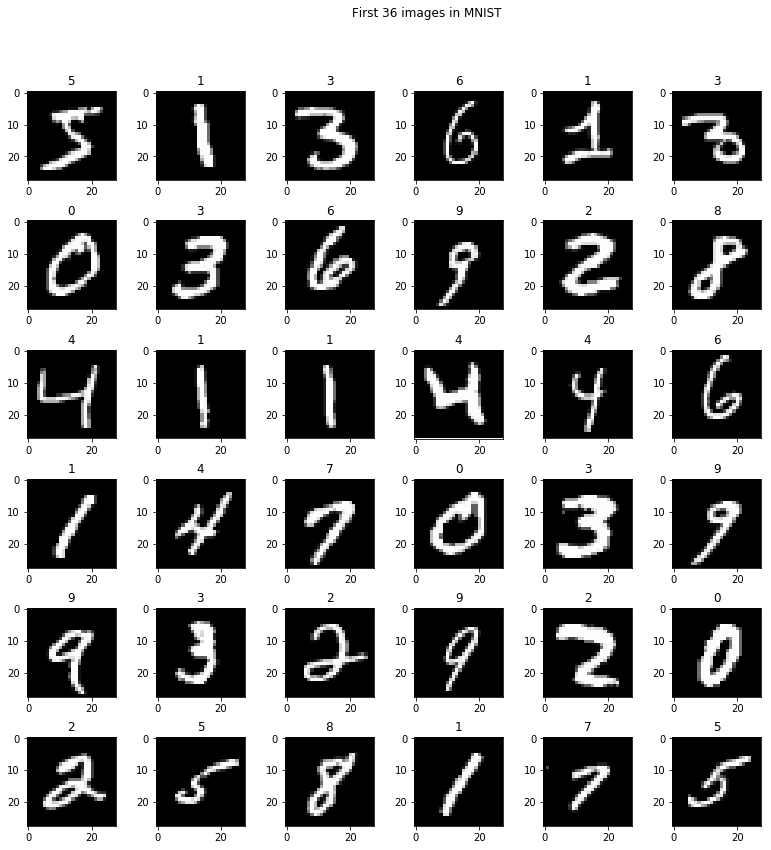

In [4]:
fig, ax = plt.subplots(6, 6, figsize = (12, 12))
fig.suptitle('First 36 images in MNIST')
fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
for x, y in [(i, j) for i in range(6) for j in range(6)]:
    ax[x, y].imshow(x_train[x + y * 6].reshape((28, 28)), cmap = 'gray')
    ax[x, y].set_title(y_train[x + y * 6])
    

A human would immediately recognize this image as an $8$, but it's missing a lot of the features we would usually associate with $8$'s in general. Fortunately, our dataset contains hundreds of examples covering most writing behaviors and idiosyncracies - we hope that our model would be robust enough to recognize $8$'s and other numbers whether or not they follow the most conventional standards for handwriting.

## Data Cleaning

Since `keras` uses Python data structures, we cannot use the standard `dplyr` methods to clean our dataframe into a form more palatable for input into our `keras` model. Fortunately, the steps in data cleaning for the MNIST dataset are very brief. For our `x` datasets, all we have to do is flatten our two-dimensional arrays of $28\times28$ pixels into $28\times28=784$-dimensional vectors, and then change the units of the grayscale values to vary from $[0,1]$ rather than $[0,255]$ (*the reason for this [will be explained later](#an-introduction-to-activation-functions)*). For our label vector $y$, we use `to_categorical` to *[one-hot-encode](https://www.quora.com/What-is-one-hot-encoding-and-when-is-it-used-in-data-science)* our labels - this command transforms our scalars $y_i \in [0,9]$ into binary class vectors $y'_i$. 

In [5]:
batch_size = 128
num_classes = 10 # 10 classes because we have 10 digits (0-9)
epochs = 5

In [6]:
# reshape 2d (28x28) image data into 1d vectors (28x28 = 784-d vectors)
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

# set type to float, then clamp data to values between 0-1 instead of integers 0 - 255
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class labels into vectors. Ie 3 -> [0,0,0,1,0,0,0,0,0,0]
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

60000 train samples
10000 test samples


Now that our data is in the proper matrix format, we're now all set to craft a `keras` deep learning model to recognize handwritten digits! But first, let's cover some of the conceptual elements behind deep learning.



# Concepts in Deep Learning

Now that you've gotten a sense for the MNIST dataset, let's learn how to actually tackle this classification problem. 

## Handwritten Digit Recognition

To reiterate the structure of this particular machine learning problem, we have a **training set** of 60k images, each represented by a $28 \times 28 = 784$-dimensional vector of numeric grayscale values. Each entry $X_i$ in our training set of example images also comes with a label, $y'_i$ to indicate which digit that particular image represents. We want to craft a model that will use the vectors to guess the labels $\hat y_i$ accurately, such that our error metric (**root mean-squared error**) is not just low for the **training set** but also in the **test set** - we want to ensure our model doesn't **overfit** to the training set, which may not be representative of all digits. The task boils down to designing a model or algorithm that preforms robustly on classifying images of digits, by learning a ruleset from 60k examples.

#### Check for Understanding
> 1. Why is our model's accuracy with the training set an insufficient metric to judge our model by? What are the implications of not evaluating your model on the test set - which is separate from the data it was trained on?

Let's take a step back for a moment. If you had to devise a collection of rules to describe to someone why the following image is a $5$, what kinds of rules would you make? Which parts of the image make it apparent to you that it's a $5$ and not some other digit?

<img src="http://neuralnetworksanddeeplearning.com/images/mnist_first_digit.png" >

> 2. Take a few minutes with a partner to devise three rules completely describing why this image is a 5. What differentiates this image from an image of a 3, or a 7?

Even if you were able to make a successful ruleset to classify this particular image of a $5$, not all $5$'s are alike. Especially for numbers like $7$, which may have a cross-through them or not, or $2$, which may have a looped tail or not, the rules quickly spiral out of reasonable specificity as we try to include more and more special cases to characterize how humans draw numeric digits.

In the past, difficult problems like image classification were met by *domain experts* who persisted through the difficulty of making these rulesets to **preprocess** data like ours into a form more interpretable by computers. Although it can be time-consuming, this process of manual **feature engineering** still remains a major component of data processing today.

To give you an idea of what feature engineering is like, let's take our example of image classification. [In the $1950$s, two researchers recorded the neural responses of a cat as its retinas were stimulated by slides of large black dots.](https://www.youtube.com/watch?v=IOHayh06LJ4) The objective of the experiment was to ascertain how the cat's brain was stimulated by the black dots. However, the researchers soon realized that it was actually the black *edges* of the slides that stimulated the cat's brain most, suggesting that our visual perception relies on **feature detection** - the filtering of an image into lines (like the edge of a slide) and simple shapes to help make sense of visual input. Humans first implicitly perceive images in terms of lines and shapes, before we cast them into more complex textures and patterns. Armed with this knowledge of human perception, we may collaborate with a linguist experienced in how humans write and perceive numbers to transform our dataset of images into a dataset of numerical **features** better suited for a method like regression analysis. For example, we could **feature engineer** our images into vectors with values about where certain lines appear, or indicators of the presence of various shapes, before we attempt to fit a model to them. With some preprocessing, our image classification problem might be more tractable. However, as our previous rule search proved, this task is quite difficult, and very complex problems resist manual feature engineering by humans. 

> 3. What are some examples of visual features our eyes might detect in images of numbers? 
> 4. Take a few minutes with a partner to fit your three rules into some sort of numeric representation (hint: a 3-dimensional vector of indicators or numeric encodings of features)

Instead of relying on manual feature engineering, we could take inspiration from how humans perceive visual input to construct our model. The initial input to the sensory neurons in our eyes is simply an array of varying light intensities - just like the initial representation of our images! - but we learn to detect features of simple and complex shapes before making sense of the image itself. For example, we may notice two circles stacked upon each other, and subsequently recognize the image as an $8$. Or, we may notice a collection of straight perpendicular lines ending in a half-circle, and recognize the image as a $5$. In our brains, the complex problem of image classification is solved by processing the data in layers, going from raw inputs to features that begin to summarize the information in the data until we finally arrive at **recognition**. 

Similarily, in deep learning, we aim to design a model that, rather than requiring preprocessing of its input, learns how to *engineer its own features* out of the raw inputs. Our model would begin with the large vector of raw grayscale intensities, and process the data in **layers**, summarizing the data in stages to ultimately arrive at recognition. Although our model would start without any awareness about our training data, by incrementally feeding all of our training data into a model, our model would slowly learn the characteristics of each category. Taking note of the problem at hand, we must also ensure our model is complex enough to capture all the nuances of the data and its labels - it is this model complexity that earns deep learning the word "*deep*" in its title. 

We must also make sure that our dataset is large and well-labeled - with enough representative examples, the performance of neural nets is statistically guaranteed to arbitrarily approximate any supervised task. In this day and age, we have the computational power and large $n$ required to effectively train complex deep learning models to solve problems like handwritten digit recognition. 

In the next few sections, you will learn about neural nets in more mathematical detail, but the mathematic structure of neural nets follows the intuition of incrementally transforming raw inputs into more and more descriptive features about the data.



## Neural Nets

Now that we've caught you up to some of the essentials of linear algebra, we will begin to discuss neural nets in more detail.

If we consider all the methods in machine learning, **neural networks** are perhaps the most celebrated, overhyped, and least understood. Neural networks became famous (or infamous) due to their unprecedented performance combined with their mysterious nature. They achieve spectacular results but under the hood, we cannot really explain how they reach the results they do. We understand how to create, train, optimize, and even visualize our deep learning models in some cases, but we do not actually understand them. Because of this, many people immediately jump to the conclusion of "ahhh Terminator!", but actually, neural networks have been known of since the $1940$s. The key algorithm in training neural networks, **back propagation** has been known since the $1990$s. We would argue that neural networks only exploded in the past few decades. So why are neural networks so popular now?



### Why Neural Networks now?

<center>
<img src="images/NNvsDeep.png">

</center>
[]( "Google Trends Neural Network vs Deep Learning")
Google Trends Neural Network vs Deep Learning

Above is a graph of google trends for neural networks and deep learning. Can you guess which color is which? Interestingly, neural networks are the blue line, and red is deep learning! Neural networks have been around for a while, and they have only recently become more popular due to new advances.

There are three main differences in machine learning now compared to $30$ years ago. 

1. More Data
2. GPUs (more computing power)
3. Better Algorithms

With time, we have been getting more and more data in all areas. The internet provides more images, text, audio than ever before. Now the issue is that we have more data than we know how to deal with. These huge datasets allow us to train deeper models.
With GPUs and more computing power, we have the ability to process more data and manage previously infeasible models. We can now train those deeper models.
With better algorithms, our models are more efficient and effective. 

Interestingly, many people agree that the second difference is the most crucial to our recent developments in machine learning. We are now capable of parsing through gigabytes, terabytes, even petabytes of data for training models hundreds of layers deep. This simply was not possible $30$ years ago. Recent improvements in GPUs has allowed models to train and perform computations in parallel, greatly speeding up the training process.




### What are Neural Networks?

Neural networks derive their name from the neural network we have in our head, our brain. In a highly simplified model, our brain is a collection of **neurons** that receive electrical input signals from **dendrites**, output electrical signals via a single **axon**. Each neuron sends signals along a single axon and connects with other dendrites. Neural networks attempt to model this by having artificial layers neurons that perform minor tasks, then communicate from layer to layer. The collection of neurons operate together to begin to understand the raw input in layers - in each layer, the neurons summarize the data a little bit further, until they finally arrive at a single label.

<center>
<img src="images/Neuron.png">

</center>

In the diagram of a neural net shown above, the circles represent nodes, or neurons, and the arrows represent the communication between nodes. These nodes are **feed forward** since the information propagates from the input on the left side through intermediate calculations to a final output layer. Our goal in machine learning is to take a set of inputs $X$ and approximate some function $f^*(X)$. We are given $(X_i,y_i)$ pairs where $y\approx f^*(x)$ is an approximation of the example relationships between $X_i$'s and $y_i$'s. These feed-forward models attempt to model $f^*(x)$ by composing multiple functions together, such as $f^*(x)=f^{(2)}(f^{(1)}(x))$ in the neural network above. Notice that $f^{(1)}(x)$ is the middle layer in the model, but it is never used except in intermediate states, thus it is known as a **hidden layer**.

The beauty of neural networks is that they automatically determine the values of these intermediate functions and chain them together to approximate the function without any *a priori* knowledge. In neural networks of images, the early layers work with simple shapes like colors and edges and work towards more complex textures, patterns, and finally to recognition of full objects. Breaking down our model into stages, or layers, takes advantage of the numerous hidden layers to create complex features from combinations of simple ones. By the end of the last layer, the raw inputs are finally condensed into one of the labels of our data - thus acheiving recognition.

### How do Neural Networks work?
<center>
![](images/NeuronModel.jpeg "Neural Network Visualization")
Images from CS231n Stanford.
</center>
Above is an image of a zoomed in an individual neuron. In this case, we have a single neuron, with multiple inputs. The general idea is to take all the inputs to the neuron from various dendrites, sum them, and perform some function on the sum. We also have a certain weight to each dendrite, so it is a linear combination of the inputs. There are many valid possible functions to perform at the end, known as *activation functions*. We will go into these in the next section.

To delve more into the math, each neuron outputs a specific value, denoted as $x_i$. This neuron then has separate weights for each further neuron it connects to and multiplies each weight to $x_i$ to serve as the input to a new neuron deeper in the model. In the image above, we have three inputs $x_0,x_1,x_2$ from three neurons. Each individual arrow from neuron to neuron has a unique weight, and each weight gets multiplied by the output axon value from the neuron. To determine the output of the blue neuron, we take the sum of the $x_iw_i$, then apply some activation function $f$. This gives us $f\left(\sum_i w_ix_i + b\right)$. The added $b$ term is not too important, essentially we also include a bias term, a constant value we add. 

#### Check for Understanding

> 1. How many weights are in the three-layer neural network image above (not counting biases)?
> 2. What happens if we use a linear activation (such as $ax+b$)?



## An Introduction to Activation Functions
To answer the second question above, consider each activation function in the neural network to be linear of the form$f^{(i)}(x)=a_ix+b_i$. Then if we compose many of these linear functions together, we would get some $f(x)=f^{(n)}(f^{(n-1)}(\ldots f^{(1)}(x)\ldots ))=ax+b$ for some $a,b$. Since the composition of multiple linear functions is always a linear function, we essentially will conduct linear regression. Without the inducement of nonlinearities, our model can only do as well as linear regression. So what activation functions can we use instead of linear functions?

There are many common activation functions. 
<center>
![](images/Relu.jpeg "Relu")

 Rectified Linear Units (ReLU) $\max(0,x)$
</center>

Rectified Linear Units (ReLU) is one of the most common activation functions used. It is simply the function $\max(0,x)$, essentially thresholding at zero. 
<center>
![](images/Sigmoid.jpeg "Sigmoid")

Sigmoid $1/(1+e^{-x})$
</center>

Sigmoid is also very commonly used as an activation function. It has the unique property of approaching $0$ as $x$ approaches $-\infty$, approaching $1$ as $x$ approaches $\infty$, and $1/2$ at $0$. This gives an inherent probability mapping from $(-\infty,infty)$, where the larger the value of $x$ the higher the probability.

<center>
![](images/Tanh.jpeg "Tanh")

 Hyperbolic Tangent ($\textit{tanh}$) 
</center>

$\textit{tanh}$ has many advantages over sigmoid since the activation function is centered at zero, and can output negative numbers. In practice, $\textit{tanh}$ is preferred over sigmoid. 


These images are from CS231n Stanford.

## How Neural Networks Learn

The general idea in machine learning is given a model and dataset, we would like to minimize the loss or error of the model as it compares to the actual labels of the data. In deep learning, this is acheived by tweaking the weights of the neural network as we incrementally train on the train data to predict the misclassified numbers better. This leads us to two major questions: $(1)$ what is the **loss function** of our model, and $(2)$ how do we update the weights of our model as we train it?

### Loss Function for Classification
As a naive attempt at creating a loss function, we could have the loss be $0$ for correctly classifying the number and $1$ for incorrect classification. However, this is a bit naive because we lose a lot of information on what the correct answer is. A better loss function for classification is **cross entropy loss**. The formula may look a bit complex but the idea is simple. For a particular label $y$ and prediction distribution $\hat{y}$, our error is:
$$z(\hat{y}) = -\sum_k y_k \log {\hat {y}}_k$$
where $y_k$ is an indicator of the correct label and $\hat{y}_k$ is our model's guess at how likely label $k$ is correct. 

For example, if the current image is actually a $3$, then $y_3=1$ and $y_i=0$ for all $i\neq 3$. The $\hat y$ represents the probability distribution outputs from our model. Our model may classify the image as $20\%$ likely to be $1$, $30\%$ likely to be $2$, $50\%$ likely to be $3$, and $0%$ for the rest. The error would be the compute to be $z(\hat y) = -\log(0.5)$.

The key thing to notice about the cross-entropy loss is that the loss drastically increases as the probability for the correct label approaches zero. If we output a very low probability for the correct class, the logarithm approaches very large negative values, resulting in a large loss. On the other hand, if we output a very high probability close to $1$ for the correct class, the loss is almost zero since $\log 1 = 0$.


#### Check for Understanding
> 1. Compute the log loss for a $7$ that was predicted to be $\hat y_7 = 90\%$ and $\hat y_1 = 10\%$. How does this match with your intuition for how cross-entropy operates?

### Back Propagation

Back propagation is the key to training neural networks. To explain back propagation, we may begin with an analogy. Consider that today after eating, you get a bad stomach ache and suspect that you got food poisoning. A logical step would be to assign blame to the most recent foods you ate, placing more blame on the more suspect foods such as raw fish, raw meats, etc. We intuitively place the blame on the more recent things, then consider the causes farther back such as the leftover salad you left in the fridge for a week or the spoiled milk from that boba place you knew you shouldn't have gone to. 

Back propagation is similar, we distribute the loss through the model beginning with the layers closer to the output, and propagate the loss back. The exact math is a bit complex as it involves a lot of derivatives, but the general idea is relatively simple. The more suspicious or the more the neuron contributed to the incorrect prediction, the more we penalize it to be correct. 

### Recap

To take a moment to recap, a neural network consists of **layers** of nodes. We feed in data to our model, and as it guesses the class of each data point, we penalize it for missclassifications. The worse the missclassification, the higher the penalty, or **loss**. These losses are then used via the back propagation algorithm to tweak the most relevant weights in the network. Over time, our weights will gradually shift to make our model more and more accurate. 

Because our weights are designed to only shift a tiny bit at a time, we pass our training set through our model multiple times to get our weights to converge to their most performant values. Each pass is known as an **epoch**, and we generally need many epochs for our model's weights to converge.

Now that you understand the basics behind how neural nets are constructed and learn from training data, let's get to actual implementations of neural nets applied to our MNIST image classification problem.



# `Keras` in Python

First, we declare our `mnist_model` to be the simplest of the deep learning architectures, a forward-feed-only **sequential** network. We then add three layers: $(1)$ a raw **input layer** with 784 nodes, one for each pixel, $(2)$ an intermediary **hidden layer** which feature engineers our raw input into 30 nodes, and finally an **output layer** which gives the 10 likelihoods for $\hat y_i$. 


In [7]:
model = Sequential()
model.add(Dense(30, activation='relu', input_shape=(784,)))
model.add(Dense(num_classes, activation='softmax'))

Note that the first hidden layer, we use the `relu` activation function for reasons outlined above, and whereas the output layer uses `softmax` to transform the weights and node values into a probability distribution of the predicted outputs.

We can verify the structure of our model with the `summary` function, just as we did for linear regression models (`lm`'s).

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                23550     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                310       
Total params: 23,860
Trainable params: 23,860
Non-trainable params: 0
_________________________________________________________________


Our "simple" model has $23,860$ parameters - clearly it's actually quite a complex model compared to linear regression models which tend to have only one parameter per input feature. The addition of the hidden layers complicated our model, but it is our hope that this additional complexity will lead to a more performant model.

Our next step is to `compile` our model by specifying that we will be using a cross-entropy loss function and a stochastic gradient descent algorithm to optimize our weights, with a learning rate of $0.1$.


In [9]:
learning_rate = 0.1
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=learning_rate),
              metrics=['accuracy'])


Now that our model is completely designed and specified, we're at the fun part - training! We use the `fit` function to train our model on the images in `training_set_x` using their labels `training_set_y`. We also specify that we will be making $5$ full passes, or **epochs**, through our training set. For computational speed, we don't train our model on a single image at a time but in batches of $100$ images each update. The full training code chunk is shown below, and `keras` will even automatically graph your loss and accuracy for you as it trains your model.


In [10]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 1s 18us/step - loss: 0.5024 - acc: 0.8630 - val_loss: 0.3047 - val_acc: 0.9130
Epoch 2/5
60000/60000 [==============================] - 1s 17us/step - loss: 0.2928 - acc: 0.9169 - val_loss: 0.2575 - val_acc: 0.9263
Epoch 3/5
60000/60000 [==============================] - 1s 16us/step - loss: 0.2457 - acc: 0.9297 - val_loss: 0.2216 - val_acc: 0.9377
Epoch 4/5
60000/60000 [==============================] - 1s 17us/step - loss: 0.2127 - acc: 0.9391 - val_loss: 0.1977 - val_acc: 0.9420
Epoch 5/5
60000/60000 [==============================] - 1s 17us/step - loss: 0.1907 - acc: 0.9449 - val_loss: 0.1830 - val_acc: 0.9459


The final step of our model is to evaluate it on the test set. Remember that a low training loss is *not* the best measure of a model's performance - we *must* try it on data it was not trained on to verify our model is robust, and didn't just overfit to the training set.


In [11]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.18302750353962183
Test accuracy: 0.9459


# `Keras` in R
Please refer to the [R version of the notebook](adv-pyr1.html).


#### Check for Understanding
> 1. Discuss the above incorrect outputs with your classmates. Why do you think our model performed badly on these inputs?
> 2. How would you improve our model to better classify inputs like the ones shown here?

# Conclusion

This ends our textbook-style primer into deep learning with Keras. While this was just an introduction to neural nets, we hope that you can now see some of the workflow patterns associated with machine learning. Feel free to play around with the code above to get a better feel for the hyperparameters of the neural net model. As always, please email [`contact@arun.run`](mailto:contact@arun.run) or [`prc@berkeley.edu`](mailto:prc@berkeley.edu) with any questions or concerns whatsoever. Happy machine learning!

## Sneakpeek at SUSA Kaggle Competition

After Spring Break, we will be guiding you through a four-week collaborative Kaggle competition with your peers in Career Exploration! We want to give you the experience of working with real data, using real machine learning algorithms, in an educational setting. You will have to choose either Python or R, and dive into reading kernels on the Kaggle website, use visualization and feature engineering to improve your score, and maybe even pick up a few advanced deep learning models along the way. If this sounds a bit intimidating right now, do not fret! Your SUSA Mentors will be there to mentor you through the whole thing. So rest up during Spring Break, and come back ready to tackle your biggest data challenge yet!

# Additional Reading
* This workshop was based on the introductory example for [Keras in R](https://blog.rstudio.com/2017/09/05/keras-for-r/). For more information on the R `keras` package, visit the following websites:   
    - The official RStudio website for [Keras](https://keras.rstudio.com) contains a shortened version of the MNIST illustrative example, a textbook reference, and more  
    - For a few examples on how to implement sequential neural networks like the one used in this tutorial, visit the [Keras guide to sequential models in R](https://keras.rstudio.com/articles/sequential_model.html)  
    - The official [FAQ for Keras in R](https://keras.rstudio.com/articles/faq.html) contains tons of useful information, like the differences between a **sample**, **batch**, and **epoch** as well as useful and easy one-liners to improve or validate your models
* For an interactive guide to learning R and Python, visit [DataCamp](https://www.datacamp.com/) a paid tutorial website for learning data computing.
